## Fitting the data

In [201]:
from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA.models import FSPLarge_model
from pyLIMA.outputs import pyLIMA_plots
from pyLIMA.fits import DE_fit, MCMC_fit
from pyLIMA.toolbox.brightness_transformation import (
    flux_to_magnitude,
)
import matplotlib.pyplot as plt
import numpy as np
import corner

In [202]:
data = np.load("../tutorials/assets/microlensing_dat.npz")["data"]

# Microlensing Physical Parameters
th_ein = 0.3  # Einstein radius in arcsec

# Microlensing Model Parameters
t0 = 0.2  # time at peak magnification
u0 = 0.5  # minimum impact parameter (u(t=t_0)) in units of th_ein
tE = 0.05  # Einstein timescale
rho = 1.5  # source size in units of lens Einstein radii

gamma = 0.0  # linear limb darkening coefficient

In [207]:
your_event = event.Event()
your_event.name = "Simulated Event"
telescope = telescopes.Telescope(
    name="test",
    light_curve=data,
    light_curve_names=["time", "flux", "err_flux"],
    light_curve_units=["s", "flux", "err_flux"],
)

your_event.telescopes.append(telescope)
# your_event.telescopes[0].ld_gamma = 0.5
your_event.find_survey("test")
your_event.check_event()

fspl = FSPLarge_model.FSPLargemodel(your_event)

fspl_fit = DE_fit.DEfit(
    fspl, DE_population_size=10, loss_function="chi2", max_iteration=10000
)

check_event  : Everything looks fine...


In [208]:
pyLIMA_parameters = fspl.compute_pyLIMA_parameters([t0, u0, tE, rho])

list_of_telescopes = pyLIMA_plots.create_telescopes_to_plot_model(
    fspl, pyLIMA_parameters
)
tel = list_of_telescopes[0]

In [209]:
model_magnification = fspl.model_magnification(tel, pyLIMA_parameters=pyLIMA_parameters)
fspl.derive_telescope_flux(tel, pyLIMA_parameters, model_magnification)
pyLIMA_parameters["fsource_test"] = 1.0
pyLIMA_parameters["fblend_test"] = 0.0
pyLIMA_parameters["gblend_test"] = 0.0

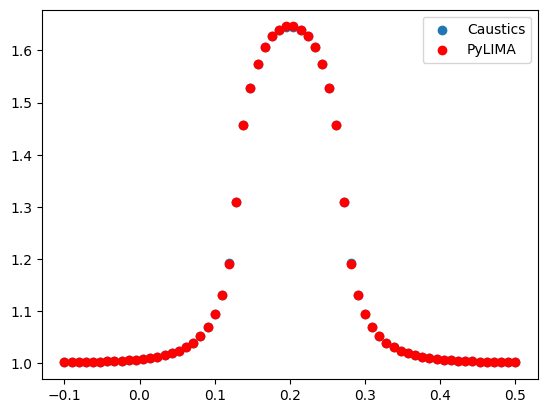

In [210]:
true_dict = {"t0": t0, "u0": u0, "tE": tE, "rho": rho}
model_magnification = fspl.model_magnification(
    telescope, pyLIMA_parameters=pyLIMA_parameters
)

magnitude = (
    pyLIMA_parameters["fsource_test"] * model_magnification
    + pyLIMA_parameters["fblend_test"]
)

plt.scatter(data[:, 0], data[:, 1], label="Caustics")
plt.scatter(data[:, 0], magnitude, color="red", label="PyLIMA")
plt.legend()

plt.show()

In [211]:
# t_E  u0   tE  rho
fspl_fit.fit_parameters["tE"][1] = (0.0, 2)
fspl_fit.fit_parameters["u0"][1] = (0.0, 2)
fspl_fit.fit_parameters["rho"][1] = [0.1, 10]
guess_parameters = [0.2, 0.3, 0.3, 1]
fspl_fit.model_parameters_guess = guess_parameters

fspl_fit.fit()

DE converge to objective function : f(x) =  0.048286163912492984
DE converge to parameters : =  ['0.1999825084624588' '0.6939697277747855' '0.047864250364016314'
 '1.628570610601166']
fit  : Differential Evolution fit SUCCESS
best_model: [0.19998251 0.69396973 0.04786425 1.62857061] chi2 0.048286163912492984


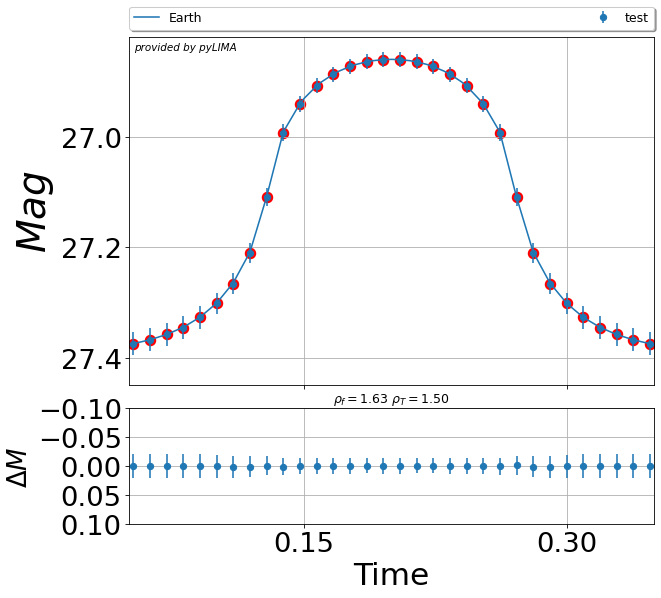

In [212]:
fig, ax = pyLIMA_plots.plot_lightcurves(fspl, fspl_fit.fit_results["best_model"])

plt.xlim(-3 * tE + t0, 3 * tE + t0)
plt.title(
    r"$\rho_f = {:.2f}$".format(fspl_fit.fit_results["best_model"][3])
    + r" $\rho_T = {:.2f}$".format(rho)
)
plt.xlabel("Time", fontsize=30)
fig.axes[0].scatter(
    data[:, 0], flux_to_magnitude(data[:, 1]), color="red", linewidths=5
)
plt.show()

In [213]:
fspl_fit.fit_results["best_model"] / [t0, u0, tE, rho]

array([0.99991254, 1.38793946, 0.95728501, 1.08571374])

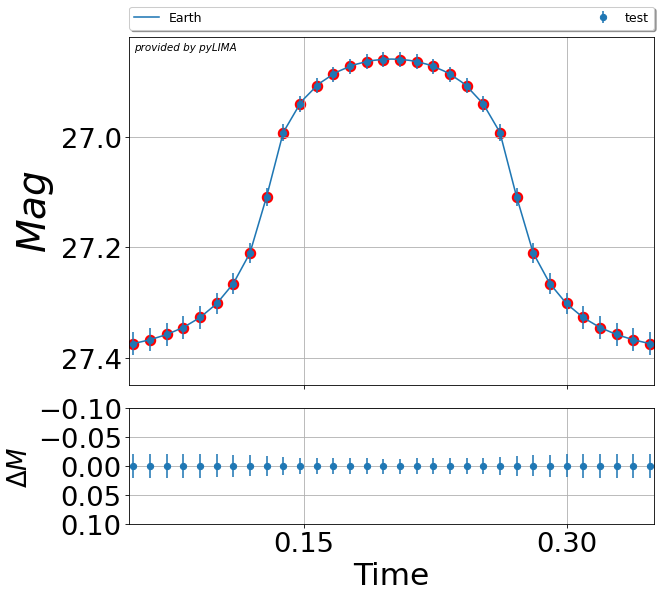

In [214]:
fig, ax = pyLIMA_plots.plot_lightcurves(fspl, [t0, u0, tE, rho])

plt.xlim(-3 * tE + t0, 3 * tE + t0)
plt.xlabel("Time", fontsize=30)

fig.axes[0].scatter(
    data[:, 0], flux_to_magnitude(data[:, 1]), color="red", linewidths=5
)
plt.show()

## MCMC

In [215]:
fspl_mcmc_fit = MCMC_fit.MCMCfit(fspl, MCMC_walkers=8, loss_function="chi2")
# fspl_mcmc_fit = MCMC_fit.MCMCfit(fspl, MCMC_walkers=4, loss_function="likelihood")
fspl_mcmc_fit.fit_parameters["t0"][1] = (-1, 1)
fspl_mcmc_fit.fit_parameters["tE"][1] = (0.0, 1)
fspl_mcmc_fit.fit_parameters["u0"][1] = [0.0, 2 * rho]
fspl_mcmc_fit.fit_parameters["rho"][1] = [0.0, 5]

# Initialize MCMC with best parameters of DE fit
fspl_mcmc_fit.model_parameters_guess = fspl_fit.fit_results["best_model"]

fspl_mcmc_fit.fit()

initial_guess  : Initial parameters guess SUCCESS
Using guess:  [0.1999825084624588, 0.6939697277747855, 0.047864250364016314, 1.628570610601166]


100%|██████████| 5000/5000 [00:29<00:00, 171.67it/s]


fit  : Monte Carlo Markov Chain (Affine Invariant) fit SUCCESS
best_model: [0.20000554 0.4848102  0.05044665 1.4832285  0.98144333 0.01841328] chi2 -0.012739731093068741


In [216]:
MCMC_results = fspl_mcmc_fit.fit_results["MCMC_chains"]
print("Parameters", " Model", "   Fit", "     Errors")
print("-----------------------------------")
print(
    "t_0:",
    "        " + str(t0) + "  ",
    str(np.median(MCMC_results[1000:, :, 0]))[:7],
    "",
    str(np.std(MCMC_results[1000:, :, 0]))[:7],
)
print(
    "u_0:",
    "        " + str(u0) + "  ",
    str(np.median(MCMC_results[1000:, :, 1]))[:7],
    "",
    str(np.std(MCMC_results[1000:, :, 1]))[:7],
)
print(
    "t_E:",
    "        " + str(tE) + " ",
    str(np.median(MCMC_results[1000:, :, 2]))[:7],
    "",
    str(np.std(MCMC_results[1000:, :, 2]))[:7],
)
print(
    "rho:",
    "        " + str(rho) + "  ",
    str(np.median(MCMC_results[1000:, :, 3]))[:7],
    "",
    str(np.std(MCMC_results[1000:, :, 3]))[:7],
)

Parameters  Model    Fit      Errors
-----------------------------------
t_0:         0.2   0.19999  0.00038
u_0:         0.5   1.01329  0.81394
t_E:         0.05  0.04347  0.00844
rho:         1.5   1.90421  0.71307


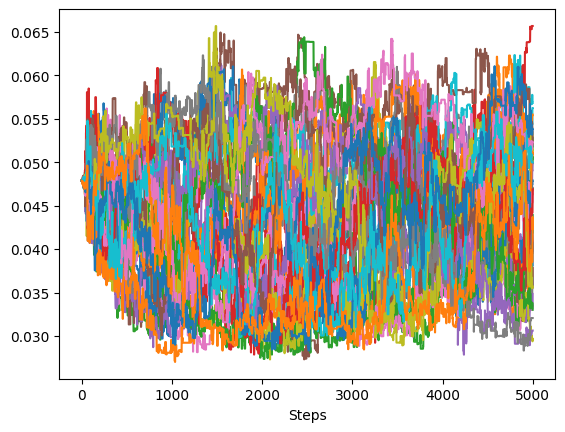

In [217]:
plt.plot(fspl_mcmc_fit.fit_results["MCMC_chains"][:, :, 2])
plt.xlabel("Steps")
# plt.ylabel("rho")
plt.show()

In [218]:
burn_in = 1000
MCMC_results_pruned = MCMC_results[burn_in:, :, :]
reshaped_results = MCMC_results_pruned.reshape(-1, 5)

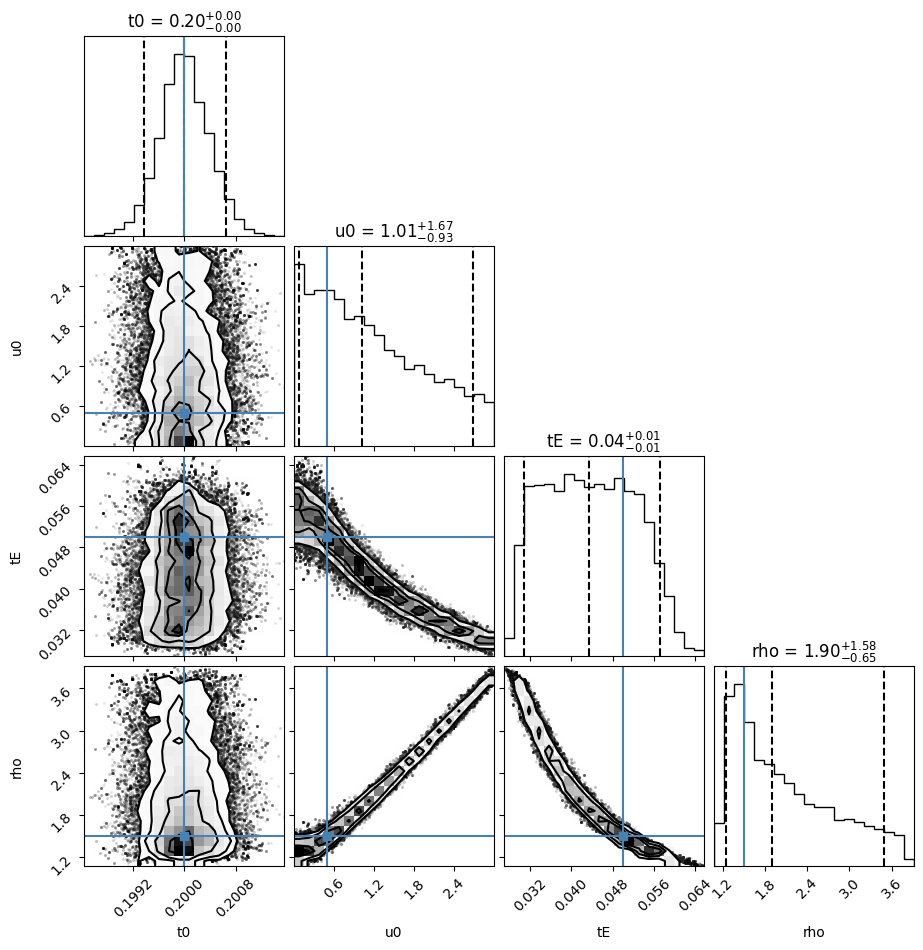

In [219]:
fspl_mcmc_fit.fit_parameters.keys()
figure = corner.corner(
    reshaped_results[:, 0:4],
    labels=[label for label in fspl_mcmc_fit.fit_parameters.keys()],
    quantiles=[0.05, 0.5, 0.95],
    truths=[t0, u0, tE, rho],
    show_titles=True,
    # range=[
    #     (0.99 * t0, 1.01 * t0),
    #     (0.3 * u0, 1.8 * u0),
    #     (0.8 * tE, 1.2 * tE),
    #     (0.6*rho, 1.4 * rho),
    # ],
)

In [220]:
mcmc_best_fit_params = np.median(reshaped_results, axis=0)

true_parameters = [t0, u0, tE, rho]

In [ ]:
fig = pyLIMA_plots.plot_lightcurves(fspl, mcmc_best_fit_params[:4])

plt.title("MCMC Median")
plt.xlabel("Time", fontsize=30)
plt.show()